In [2]:
import sys, warnings
import itertools as it

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import torch
tt =  torch.tensor
import pyro
from pyro.distributions import Bernoulli, Binomial, Delta, Exponential, Normal
from pyro.infer import Predictive
from pyro.ops.stats import hpdi, waic
import arviz as az
import seaborn as sns
from utils import plot_errorbar, train_nuts, traceplot, unnest_samples, plot_intervals

In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 20 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

pandas    : 2.2.2
numpy     : 1.26.4
arviz     : 0.17.1
pyro      : 1.9.1
matplotlib: 3.9.0
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
torch     : 2.3.0
seaborn   : 0.12.2
scipy     : 1.12.0

Watermark: 2.4.3



Finally, we get to hierarchical models. I've been looking forward to this chapter for a while now. Hierarchical (or multilevel) models basically use data at multiple different levels of granularity to squeeze as much statistical power out as possible. For example, if you want to measure the waiting time at multiple cafes, then you can either
1. Measure the average waiting time of each separately
2. Measure the average waiting time of all of them together
3. Use the distribution of all waiting times as the prior, then learn a posterior distribution for each cafe

Options 1 and 2 are sub-optimal, because in option 1, learning something about the waiting times of one cafe does nothing to help you learn the waiting times at other cafes. They're likely to be at least somewhat similar to each other, right? In option 2, you'll get the same output for every cafe. But each one has some degree of variation, right? Option 3 allows you to combine both 1 & 2 to get the best of both worlds.

### Code 13.21 - 13.25
Now we're going to turn up the complexity a bit. We'll look at the chimpanzee experiment (pulling levers thing from earlier chapter), and analyze it in the context of a multilevel model with categorical predictors. In this experiment not only do we have 7 different actors, but the experiment was performed across 6 different days (blocks); there may be different intercepts for different actors/blocks.

In [4]:
chimp_df = pd.read_csv("data/chimpanzees.csv", sep=";")
chimp_df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [5]:
df = chimp_df
df["treatment"] = df["prosoc_left"] + 2*df["condition"]
data = dict(
    pulled_left=tt(df["pulled_left"].values).double(),
    actor=tt(df["actor"].values-1).long(),
    block_id=tt(df["block"].values-1).long(),
    treatment=tt(df["treatment"].values).long(),
    n_actors=df["actor"].nunique(),
    n_blocks=df["block"].nunique(),
    n_treatments=df["treatment"].nunique(),
)

The model will have two parameters, $\gamma_\text{BLOCK[i]}$, and $\alpha_\text{ACTOR[i]}$, which have adaptive priors:

$$\begin{align*}
L_i &\sim \text{Bernoulli}(p_i) \\
p_i &= \exp\left( \alpha_\text{ACTOR[i]} + \gamma_\text{BLOCK[i]} + \beta_\text{TREATMENT[i]} \right) \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma_\alpha);\quad j=1,\cdots,7 \\
\gamma_j &\sim \text{Normal}(0, \sigma_\gamma);\quad j=1,\cdots,6 \\
\beta_j &\sim \text{Normal}(0, 0.5);\quad j=1,\cdots,4 \\
\bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
\sigma_\alpha &\sim \text{Exponential}(1) \\
\sigma_\gamma &\sim \text{Exponential}(1)
\end{align*}$$

In [6]:
def model_m13_4(data, training=False):
    nA, nB, nT = [data[k] for k in ("n_actors", "n_blocks", "n_treatments")]
    # Hyper-priors
    α_bar = pyro.sample("α_bar", Normal(0., 1.5))
    σ_α = pyro.sample("σ_α", Exponential(1.))
    σ_γ = pyro.sample("σ_γ", Exponential(1.))

    # Adaptive Priors
    α = pyro.sample("α", Normal(α_bar, σ_α).expand([nA]).to_event(0))
    γ = pyro.sample("γ", Normal(0., σ_γ).expand([nB]).to_event(0))
    
    β = pyro.sample("β", Normal(0., 0.5).expand([nT]).to_event(0))
    A, B, T = [data[k] for k in ("actor", "block_id", "treatment")]
    p = torch.sigmoid(α[A] + γ[B] + β[T])
    if training:
        pyro.sample("L", Bernoulli(p), obs=data["pulled_left"])
    else:
        return pyro.sample("L", Bernoulli(p))

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", torch.jit.TracerWarning)
    m13_4 = train_nuts(model_m13_4, data, 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:19, 129.45it/s, step size=3.37e-01, acc. prob=0.699]


In [8]:
m13_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      α[0]     -0.33      0.38     -0.32     -0.99      0.25    270.78      1.02
      α[1]      4.78      1.52      4.43      2.49      6.69     58.74      1.00
      α[2]     -0.69      0.38     -0.68     -1.24     -0.03    210.31      1.00
      α[3]     -0.68      0.37     -0.67     -1.30     -0.12    182.72      1.00
      α[4]     -0.35      0.35     -0.36     -0.93      0.23    432.08      1.00
      α[5]      0.56      0.38      0.60     -0.10      1.10    164.61      1.00
      α[6]      2.09      0.45      2.04      1.38      2.82    368.16      1.00
     α_bar      0.58      0.76      0.54     -0.62      1.75    238.55      1.00
      β[0]     -0.11      0.30     -0.10     -0.60      0.34    231.99      1.00
      β[1]      0.38      0.30      0.41     -0.07      0.89    242.99      1.01
      β[2]     -0.48      0.29     -0.49     -1.02     -0.06    358.02      1.01
      β[3]      0.28      0

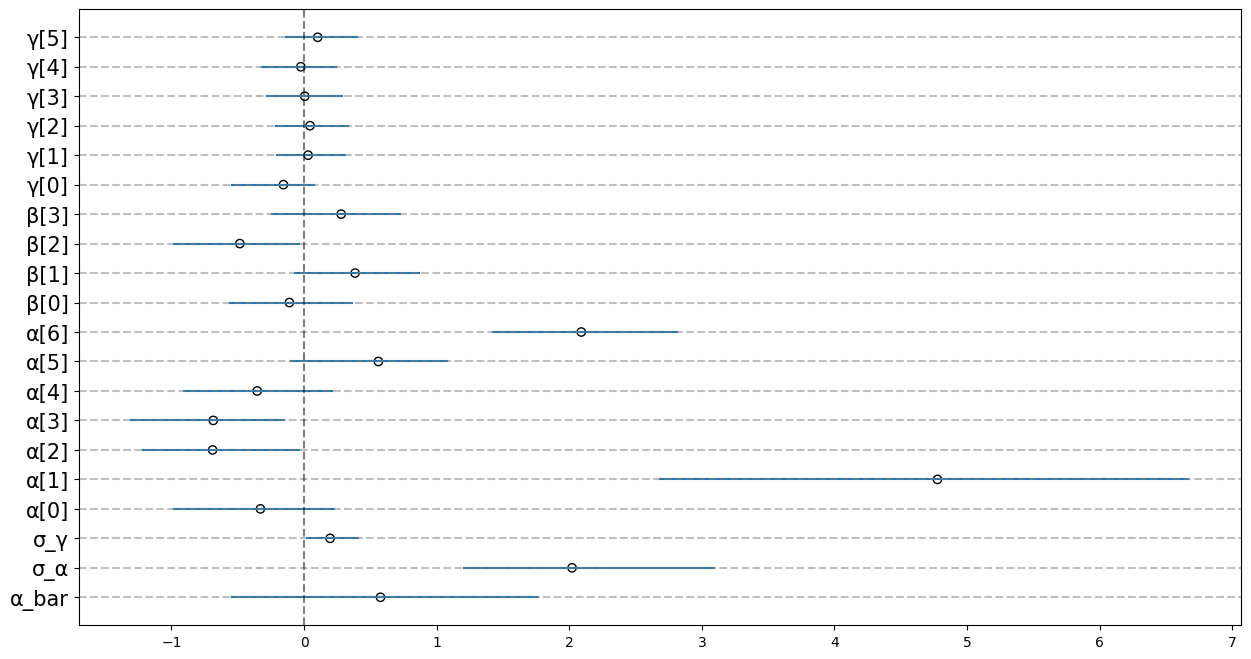

In [9]:
plt.figure(figsize=(15, 8))
samples = {k: v.numpy() for k, v in unnest_samples(m13_4.get_samples()).items()}
plot_intervals(samples, 0.89); plt.show()

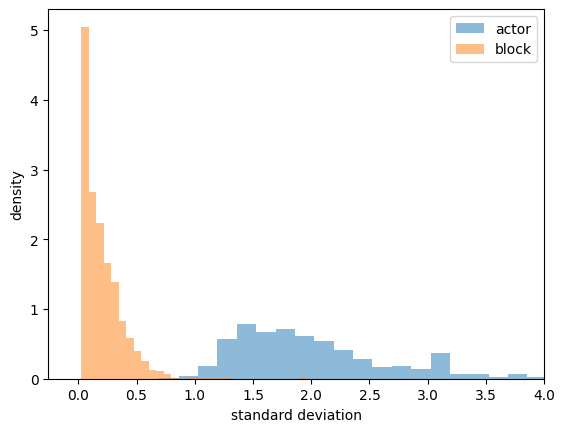

In [10]:
params = dict(density=True, bins=30, alpha=0.5)
plt.hist(samples["σ_α"], label="actor", **params)
plt.hist(samples["σ_γ"], label="block", **params)
plt.xlabel("standard deviation")
plt.ylabel("density")
plt.xlim(right=4)
plt.legend()
plt.show()

We can see that there are widely varying values of `n_eff` for different parameters, as well as the appearance of some _divergent transitions_. Our model is apparently having a bit of trouble sampling from the posterior here; why could that be? Well, one thing that sticks out is that the estimate for $\sigma_\gamma$ is pretty small, and spends a lot of time near its lower boundary of zero. The estimates for the $\gamma_j$'s are all pretty close to zero as well; it doesn't seem like including the block ID as a predictor is all that useful. Why don't we get rid of it and see if that improves things?

In [11]:
def model_m13_5(data, training=False):
    nA, nT = [data[k] for k in ("n_actors", "n_treatments")]
    α_bar = pyro.sample("α_bar", Normal(0., 1.5))
    σ_α = pyro.sample("σ_α", Exponential(1.))
    α = pyro.sample("α", Normal(α_bar, σ_α).expand([nA]).to_event(0))
    β = pyro.sample("β", Normal(0., 0.5).expand([nT]).to_event(0))
    A, T = [data[k] for k in ("actor", "treatment")]
    p = torch.sigmoid(α[A] + β[T])
    if training:
        pyro.sample("L", Bernoulli(p), obs=data["pulled_left"])
    else:
        return pyro.sample("L", Bernoulli(p))

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", torch.jit.TracerWarning)
    m13_5 = train_nuts(model_m13_5, data, 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:10, 247.90it/s, step size=4.34e-01, acc. prob=0.900]


In [13]:
m13_5.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      α[0]     -0.33      0.34     -0.33     -0.88      0.24    487.38      1.00
      α[1]      4.63      1.25      4.44      2.78      6.45    582.16      1.00
      α[2]     -0.62      0.35     -0.62     -1.15     -0.01    512.28      1.00
      α[3]     -0.63      0.36     -0.64     -1.18     -0.03    565.27      1.00
      α[4]     -0.33      0.34     -0.32     -0.87      0.26    533.19      1.00
      α[5]      0.61      0.35      0.61      0.06      1.19    505.22      1.00
      α[6]      2.12      0.45      2.11      1.39      2.87    625.65      1.00
     α_bar      0.61      0.72      0.60     -0.56      1.84   1188.97      1.00
      β[0]     -0.15      0.31     -0.15     -0.71      0.31    482.32      1.00
      β[1]      0.37      0.30      0.36     -0.13      0.86    487.91      1.00
      β[2]     -0.50      0.31     -0.49     -0.95      0.05    481.32      1.00
      β[3]      0.26      0

That improved things a little; `n_eff` is a bit higher and there are no more divergences. Why don't we compare the models?

In [14]:
samples = m13_4.get_samples()
log_p = []
for i in range(2000):
    s = {k: v[i] for k, v in samples.items()}
    tr = pyro.poutine.trace(pyro.condition(model_m13_4, data=s)).get_trace(data, True)
    obs = tr.nodes["L"]
    log_p.append(obs["fn"].log_prob(data["pulled_left"]))
log_p = torch.stack(log_p, dim=0)
w1, n = waic(log_p, pointwise=True)
se = torch.sqrt(len(w1)*w1.var())
print(f"model 13.4 (with block ID): WAIC={w1.sum().item():.1f}, n_eff={n.sum().item():.1f}, std. err.={se.item():.1f}")

model 13.4 (with block ID): WAIC=532.8, n_eff=10.8, std. err.=19.3


In [15]:
samples = m13_5.get_samples()
log_p = []
for i in range(2000):
    s = {k: v[i] for k, v in samples.items()}
    tr = pyro.poutine.trace(pyro.condition(model_m13_5, data=s)).get_trace(data, True)
    obs = tr.nodes["L"]
    log_p.append(obs["fn"].log_prob(data["pulled_left"]))
log_p = torch.stack(log_p, dim=0)
w2, n = waic(log_p, pointwise=True)
se = torch.sqrt(len(w2)*w2.var())
print(f"model 13.5 (w/o block ID): WAIC={w2.sum().item():.1f}, n_eff={n.sum().item():.1f}, std. err.={se.item():.1f}")

model 13.5 (w/o block ID): WAIC=530.8, n_eff=8.3, std. err.=19.2


In [16]:
diff = torch.sqrt(len(w1)*(w1 - w2).var()).item()
print(f"std. err. of difference in WAIC: {diff:.1f}")

std. err. of difference in WAIC: 1.6


In [17]:
keys = ['α',  'γ', 'α_bar', 'β',  'σ_α', 'σ_γ']
# 'x', 'z', 'α_bar', 'β', 'σ_α', 'σ_γ'
print(keys)
d = m13_4.diagnostics()
n_eff_c = [d[k]["n_eff"].numpy() for k in keys]


['α', 'γ', 'α_bar', 'β', 'σ_α', 'σ_γ']


There isn't much difference between the two... the total difference in WAIC between the two models is comparable to the std. error of the pointwise difference, so the inclusion of $\gamma$ doesn't bring much to the table apparently.

We can also try pooling the `treatment` effects as well, but there is not much of a difference:

In [18]:
def model_m13_6(data, training=False):
    nA, nB, nT = [data[k] for k in ("n_actors", "n_blocks", "n_treatments")]
    α_bar = pyro.sample("α_bar", Normal(0., 1.5))
    σ_α = pyro.sample("σ_α", Exponential(1.))
    σ_γ = pyro.sample("σ_γ", Exponential(1.))
    σ_β = pyro.sample("σ_β", Exponential(1.))
    α = pyro.sample("α", Normal(α_bar, σ_α).expand([nA]).to_event(0))
    γ = pyro.sample("γ", Normal(0., σ_γ).expand([nB]).to_event(0))
    β = pyro.sample("β", Normal(0., σ_β).expand([nT]).to_event(0))
    A, B, T = [data[k] for k in ("actor", "block_id", "treatment")]
    p = torch.sigmoid(α[A] + γ[B] + β[T])
    if training:
        pyro.sample("L", Bernoulli(p), obs=data["pulled_left"])
    else:
        return pyro.sample("L", Bernoulli(p))

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", torch.jit.TracerWarning)
    m13_6 = train_nuts(model_m13_6, data, 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/2500 [00:00, ?it/s]

Sample: 100%|██████████| 2500/2500 [00:54, 46.18it/s, step size=9.03e-02, acc. prob=0.969]


In [20]:
print("model 13.6 β's:", m13_6.get_samples()["β"].mean(dim=0).numpy())
print("model 13.4 β's:", m13_4.get_samples()["β"].mean(dim=0).numpy())

model 13.6 β's: [-0.11877481  0.37920238 -0.45071023  0.27383853]
model 13.4 β's: [-0.11060684  0.38489646 -0.48375094  0.28021608]


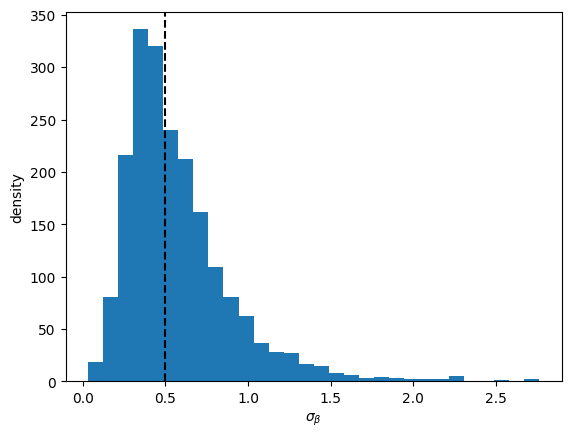

In [21]:
# the distribution of σ_β is pretty tightly clustered around the value of
# the parameter we assigned it in the model without pooling (0.5):
x = m13_6.get_samples()["σ_β"]
plt.hist(x, bins=30)
plt.axvline(0.5, color="black", linestyle="--")
plt.xlabel(r"$\sigma_\beta$")
plt.ylabel("density")
plt.show()

### Code 13.26 - 13.30
You'll notice that in some of the previous models, the HMC runs produced several _divergent transitions_. A small number of these is usually nothing to fret over, but it does signal that there might be some inefficiencies in the way the kernel is sampling, which could cause problems in more complex models.

Recall that HMC is basically a physics simulation where a particle slides frictionlessly over some potential energy surface determined by the posterior distribution. If that potential energy is too steep in certain areas, it can make sampling difficult because of numerical problems (energy not being conserved to numerical tolerances, etc). Here's an example of a simple problem that illustrates the issue, called the _Devil's Funnel_.

$$
v \sim \text{Normal}(0, 3) \\
x \sim \text{Normal}(0, \exp(v))
$$

There really isn't any data to sample from, but we can run the simulation anyway

In [22]:
def model_m13x(data, training=False):
    v = pyro.sample("v", Normal(0., 3.))
    x = pyro.sample("x", Normal(0., torch.exp(v)))
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore", torch.jit.TracerWarning)
    m13x = train_nuts(model_m13x, dict(), 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:11, 217.42it/s, step size=3.11e-01, acc. prob=0.603]


In [23]:
m13x.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         v      1.45      2.53      1.28     -1.86      5.28     11.62      1.00
         x     49.41    188.30     -0.05    -74.76    172.98     19.68      1.09

Number of divergences: 460


array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

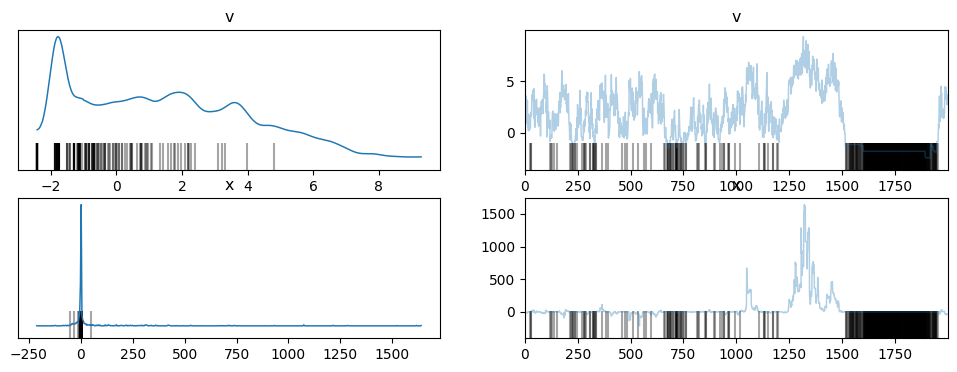

In [24]:
az.plot_trace(az.from_pyro(m13x))

We can see that the results are clearly fucked up for such a simple model! Over a hundred divergent transitions, the distribution of $x$ is all over the place, the $n_\text{eff}$ are a tiny fraction of the actual samples, the $\hat{R}$ diagnostics are no good, and the traceplots show that the chain is obviously sick!

So what we can do to help fix this problems is something called the _reparametrization trick_. If you think about it, you can transform a sample from any normal distribution (with arbitrary mean and std deviation) into a linear transformation of a sample from a _standard_ normal:

$$
x \sim \text{Normal}(\mu, \sigma) \iff
x = \mu + \sigma z, \text{  where  } z \sim \text{Normal}(0, 1)
$$

There are many types of distributions that can be reparametrized in this way (although many can't, such as ones with discrete support). Let's redo the Devil's Funnel using this trick and see how it improves the sampling:

In [25]:
def model_m13y(data, training=False):
    v = pyro.sample("v", Normal(0., 3.))
    z = pyro.sample("z", Normal(0., 1.))
    x = pyro.deterministic("x", z*torch.exp(v))
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore", torch.jit.TracerWarning)
    m13y = train_nuts(model_m13y, dict(), 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:02, 885.31it/s, step size=8.24e-01, acc. prob=0.928]


In [26]:
m13y.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         v     -0.00      2.98     -0.06     -4.94      4.81   1986.35      1.00
         z      0.02      1.04      0.03     -1.73      1.68   1095.88      1.00

Number of divergences: 0


In [27]:
s = {k: v[None,:] for k, v in m13y.get_samples().items()}
s["x"] = s["z"]*torch.exp(s["v"])
pyro.infer.mcmc.util.print_summary(s)
print("Number of divergences:", len(m13y.diagnostics()["divergences"]["chain 0"]))


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         v     -0.00      2.98     -0.06     -4.94      4.81   1986.35      1.00
         z      0.02      1.04      0.03     -1.73      1.68   1095.88      1.00
         x      4.48    436.84      0.00    -25.54     30.83   1841.01      1.00

Number of divergences: 0


array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

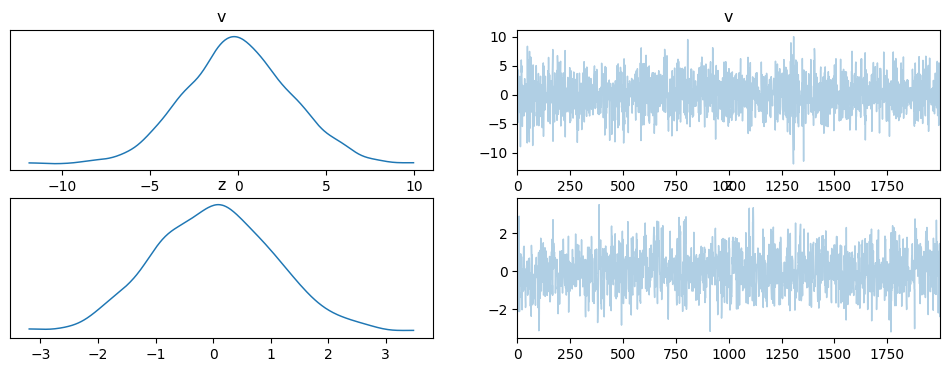

In [28]:
az.plot_trace(az.from_pyro(m13y))

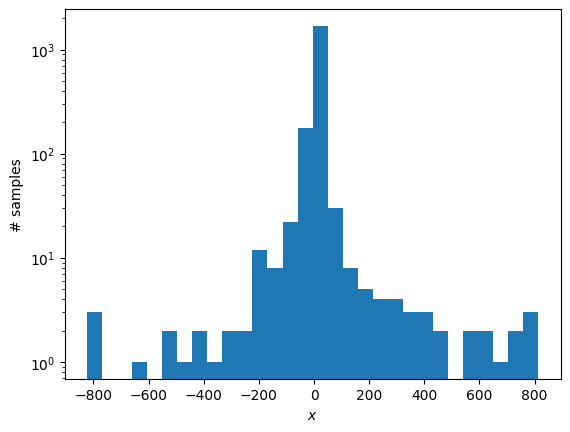

In [29]:
x = s["x"]
plt.hist(x[(-1000<x) & (x<1000)], bins=30, density=False)
plt.yscale("log")
plt.xlabel(r"$x$")
plt.ylabel("# samples")
plt.show()

Not only did it speed things up, it improved the sample efficiency and $\hat{R}$ diagnostic. Our sick chain is now healthy and sampling efficiently. The reason the "centered parametrization" (not using the reparametrization trick) ended up making HMC perform so poorly was because certain values of $\exp(v)$ cause a very narrow valley which makes taking gradient steps difficult (i.e. small values of $v$).

/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


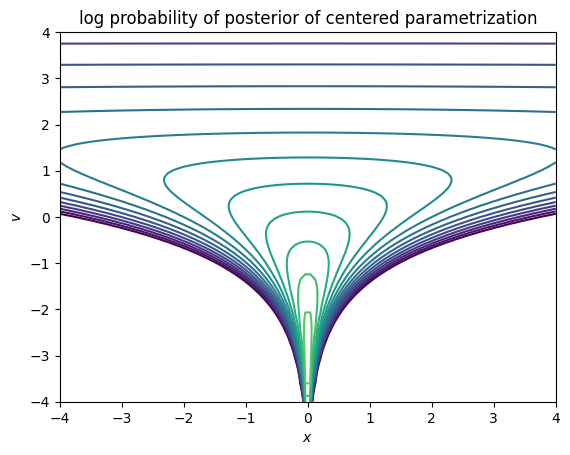

In [30]:
grid = torch.linspace(-4, 4, 100)
x, v = torch.meshgrid([grid, grid])
logp = Normal(0., torch.exp(v)).log_prob(x) + Normal(0., 3.).log_prob(v)
plt.contour(x, v, logp, levels=torch.linspace(-10, 2, 20))
plt.xlabel(r"$x$")
plt.ylabel(r"$v$")
plt.title("log probability of posterior of centered parametrization")
plt.show()

The non-centered parametrization has no such problem because it is just the joint distribution of two normals (with reasonable parameters).

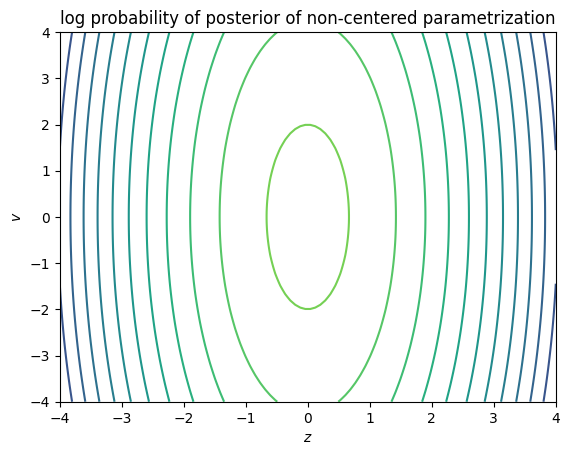

In [31]:
grid = torch.linspace(-4, 4, 100)
z, v = torch.meshgrid([grid, grid])
logp = Normal(0., 1.).log_prob(z) + Normal(0., 3.).log_prob(v)
plt.contour(z, v, logp, levels=torch.linspace(-15, 0, 20))
plt.xlabel(r"$z$")
plt.ylabel(r"$v$")
plt.title("log probability of posterior of non-centered parametrization")
plt.show()

Now we want to use this trick to help us with the chimpanzee inference. If we recall the model we used for `m13_4`, it has two adaptive priors,

$$
\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_\alpha) \\
\gamma_j \sim \text{Normal}(0, \sigma_\gamma)
$$

which we can reparametrize like

$$
\alpha_j = \bar{\alpha} + \sigma_\alpha x_j \\
\gamma_j = \sigma_\gamma z_j \\
x_j, z_j \sim \text{Normal}(0, 1) \\
$$

In [32]:
def model_m13_4nc(data, training=False):
    nA, nB, nT = [data[k] for k in ("n_actors", "n_blocks", "n_treatments")]
    α_bar = pyro.sample("α_bar", Normal(0., 1.5))
    σ_α = pyro.sample("σ_α", Exponential(1.))
    σ_γ = pyro.sample("σ_γ", Exponential(1.))
    # use the reparametrization trick
    x = pyro.sample("x", Normal(0., 1.).expand([nA]).to_event(0))
    z = pyro.sample("z", Normal(0., 1.).expand([nB]).to_event(0))
    α = pyro.deterministic("α", α_bar + σ_α*x)
    γ = pyro.deterministic("γ", σ_γ*z)
    β = pyro.sample("β", Normal(0., 0.5).expand([nT]).to_event(0))
    A, B, T = [data[k] for k in ("actor", "block_id", "treatment")]
    p = torch.sigmoid(α[A] + γ[B] + β[T])
    if training:
        pyro.sample("L", Bernoulli(p), obs=data["pulled_left"])
    else:
        return pyro.sample("L", Bernoulli(p))

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", torch.jit.TracerWarning)
    m13_4nc = train_nuts(model_m13_4nc, data, 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:47, 52.96it/s, step size=1.18e-01, acc. prob=0.931]


This actually seems to run slower than before (when the centered parametrization was being used), which is kind of surprising, but might be expected since we are introducing additional multiply and add operations. On the other hand, we can also see that `n_eff` is typically significantly higher (note this is using the same # of samples), and there are no divergences anymore!

In [34]:
m13_4nc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]     -0.51      0.39     -0.50     -1.20      0.07    510.56      1.00
      x[1]      2.13      0.64      2.10      1.15      3.19    766.08      1.00
      x[2]     -0.68      0.41     -0.67     -1.35     -0.02    510.99      1.00
      x[3]     -0.68      0.41     -0.66     -1.34     -0.00    504.16      1.00
      x[4]     -0.52      0.39     -0.51     -1.13      0.15    506.13      1.00
      x[5]      0.01      0.36     -0.00     -0.56      0.62    482.47      1.00
      x[6]      0.84      0.45      0.81      0.10      1.55    563.07      1.00
      z[0]     -0.65      0.88     -0.70     -2.10      0.78   2022.38      1.00
      z[1]      0.14      0.87      0.16     -1.25      1.61   2076.60      1.00
      z[2]      0.21      0.88      0.22     -1.23      1.64   2189.92      1.00
      z[3]      0.05      0.87      0.05     -1.36      1.53   2045.06      1.00
      z[4]     -0.13      0

(20,) ['x', 'z', 'α_bar', 'β', 'σ_α', 'σ_γ']
(2, 20)
α[0] 	α[1] 	α[2] 	α[3] 	α[4] 	α[5] 	α[6] 	γ[0] 	γ[1] 	γ[2] 	γ[3] 	γ[4] 	γ[5] 	α_bar 	β[0] 	β[1] 	β[2] 	β[3] 	σ_α 	σ_γ 	
270.8 	58.7 	210.3 	182.7 	432.1 	164.6 	368.2 	135.8 	1251.8 	1191.9 	1247.5 	1132.1 	286.6 	238.5 	232.0 	243.0 	358.0 	227.6 	115.6 	49.2 	
510.6 	766.1 	511.0 	504.2 	506.1 	482.5 	563.1 	2022.4 	2076.6 	2189.9 	2045.1 	1744.4 	1774.8 	453.8 	635.2 	938.9 	865.4 	792.7 	625.6 	824.9 	
False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	False 	

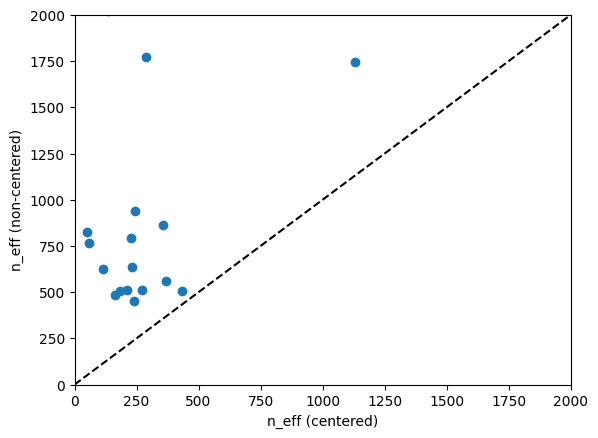

In [45]:
keys = list(m13_4nc.diagnostics().keys())[:-2]
n_eff_c = np.hstack(n_eff_c)
print(n_eff_c.shape, keys)
d = m13_4nc.diagnostics()
d = [d[k]["n_eff"].numpy() for k in keys]
n_eff_nc = np.hstack(d)

neff = np.vstack([n_eff_c, n_eff_nc])
print(neff.shape)
keys = ['α',  'γ', 'α_bar', 'β',  'σ_α', 'σ_γ']
names= ['α[0]', 'α[1]', 'α[2]', 'α[3]', 'α[4]', 'α[5]', 'α[6]',\
        'γ[0]', 'γ[1]', 'γ[2]', 'γ[3]', 'γ[4]', 'γ[5]',\
        'α_bar',\
        'β[0]', 'β[1]', 'β[2]', 'β[3]',\
        'σ_α', 'σ_γ']
for x in names:
        print(x, "\t", end="")
print()
for j in range(neff.shape[0]):
    for i in range(neff.shape[1]):
        print(neff[j,i].round(1), "\t", end="")
    print()

for i in range(neff.shape[1]):
        print(neff[0,i].round(1) > neff[1,i].round(1), "\t", end="")

plt.scatter(neff[0,:], neff[1,:])
plt.xlabel("n_eff (centered)")
plt.ylabel("n_eff (non-centered)")
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.axline((0, 0), slope=1, linestyle='--', color='k')
plt.show()

But does this mean that we should always use the non-centered parametrization when we can? The answer is... it depends. Sometimes it is better to use the centered parametrization. Sometimes it is best to use both parametrizations for different clusters in the same model. The general rule of thumb is that if you have low variation within a cluster or a lot of units in certain cluster (but not much data for each unit), the non-centered parametrization might be better. You might have to experiment with it.

There are also other distributions that can be reparametrized in addition to the normal, such as the exponential:

$$
x \sim \text{Exponential}(\lambda) \iff
x = \lambda z \text{  where  }
z \sim \text{Exponential}(1)
$$

You can do this with other distributions like the uniform, gamma, cauchy, etc.

### Code 13.31 - 13.??
Let's look at the posterior predictions for our models. We would note that models with pooling actually are less likely to match data points than unpooled models due to shrinkage, but that they are _more_ likely to match unseen or new data points. Here's how we would do the prediction for an in-sample cluster:

In [36]:
def model_m13_4(data, training=False):
    nA, nB, nT = [data[k] for k in ("n_actors", "n_blocks", "n_treatments")]
    α_bar = pyro.sample("α_bar", Normal(0., 1.5))
    σ_α = pyro.sample("σ_α", Exponential(1.))
    σ_γ = pyro.sample("σ_γ", Exponential(1.))
    α = pyro.sample("α", Normal(α_bar, σ_α).expand([nA]).to_event(0))
    γ = pyro.sample("γ", Normal(0., σ_γ).expand([nB]).to_event(0))
    β = pyro.sample("β", Normal(0., 0.5).expand([nT]).to_event(0))
    A, B, T = [data[k] for k in ("actor", "block_id", "treatment")]
    p = torch.sigmoid(α[A] + γ[B] + β[T])
    if training:
        pyro.sample("L", Bernoulli(p), obs=data["pulled_left"])
    else:
        return pyro.sample("L", Bernoulli(p))

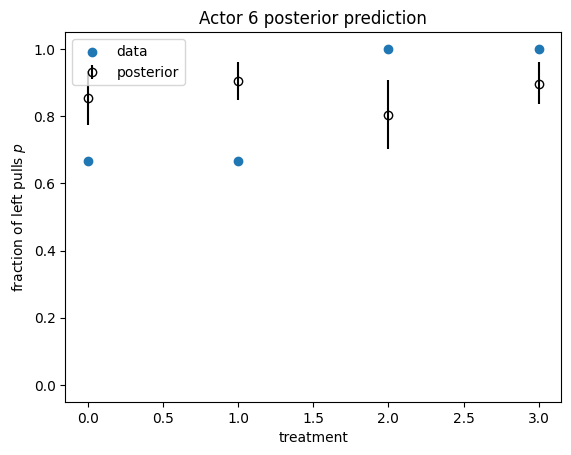

In [37]:
chimp = 6
_data = {
    "n_actors": chimp_df["actor"].nunique(),
    "n_blocks": chimp_df["block"].nunique(),
    "n_treatments": chimp_df["treatment"].nunique(),
    "actor": tt(4*[chimp]),
    "treatment": tt([0,1,2,3]),
    "block_id": tt(4*[0])
}
s = m13_4.get_samples()
p = torch.sigmoid(s["α"][:,_data["actor"]] + s["γ"][:,_data["block_id"]] + s["β"][:,_data["treatment"]])
p_mu = p.mean(dim=0)
p_ci = hpdi(p, 0.89, dim=0)

# plot posterior prediction
plt.errorbar(
    x=[0,1,2,3], 
    y=p_mu,
    yerr=(p_ci-p_mu).abs(),
    marker="o",
    markerfacecolor="none",
    color="black",
    linestyle="none",
    label="posterior"
)
mask = (chimp_df["actor"]==chimp+1) & (chimp_df["block"]==1)
d = chimp_df[mask].groupby("treatment")["pulled_left"].mean()
plt.scatter(d.index, d.values, color="C0", label="data")
plt.legend()
plt.title(f"Actor {chimp} posterior prediction")
plt.xlabel("treatment")
plt.ylabel(r"fraction of left pulls $p$")
plt.ylim(bottom=-0.05, top=1.05)
plt.show()

What if we want to get predictions for a _new_ cluster (i.e. actor)? We can't use any of the individual $\alpha$ parameters because those are specific to the actors we did observe. But we can use our adaptive prior $\text{Normal}(\bar{\alpha}, \sigma_\alpha)$ to help us out. We can imagine the "average" actor has an $\alpha$ of $\bar{\alpha}$, and (with the additional assumption that $\gamma=0$), we can easily simulate some data for this "average" actor.

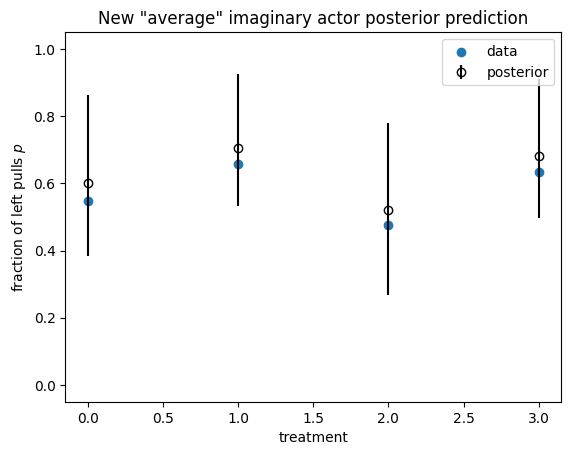

In [38]:
p = torch.sigmoid(s["α_bar"][:,None] + s["β"][:,_data["treatment"]])
p_mu = p.mean(dim=0)
p_ci = hpdi(p, 0.89, dim=0)
# plot posterior prediction
plt.errorbar(
    x=[0,1,2,3], 
    y=p_mu,
    yerr=(p_ci-p_mu).abs(),
    marker="o",
    markerfacecolor="none",
    color="black",
    linestyle="none",
    label="posterior"
)
d = chimp_df.groupby(["treatment"])["pulled_left"].mean().reset_index()
plt.scatter(d["treatment"], d["pulled_left"], color="C0", label="data")
plt.legend()
plt.title(f"New \"average\" imaginary actor posterior prediction")
plt.xlabel("treatment")
plt.ylabel(r"fraction of left pulls $p$")
plt.ylim(bottom=-0.05, top=1.05)
plt.show()

But this doesn't take into account the variation between actors, $\sigma_\alpha$. Let's simulate using that:

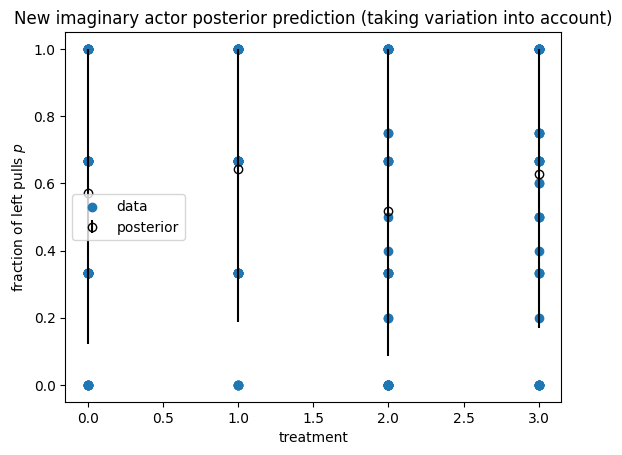

In [39]:
a = s["α_bar"] + s["σ_α"]*torch.randn(s["α_bar"].shape[0])
p = torch.sigmoid(a[:,None] + s["β"][:,_data["treatment"]])
p_mu = p.mean(dim=0)
p_ci = hpdi(p, 0.89, dim=0)
# plot posterior prediction
plt.errorbar(
    x=[0,1,2,3], 
    y=p_mu,
    yerr=(p_ci-p_mu).abs(),
    marker="o",
    markerfacecolor="none",
    color="black",
    linestyle="none",
    label="posterior"
)
d = chimp_df.groupby(["actor","block","treatment"])["pulled_left"].mean().reset_index()
plt.scatter(d["treatment"], d["pulled_left"], color="C0", label="data")
plt.legend()
plt.title(f"New imaginary actor posterior prediction (taking variation into account)")
plt.xlabel("treatment")
plt.ylabel(r"fraction of left pulls $p$")
plt.ylim(bottom=-0.05, top=1.05)
plt.show()

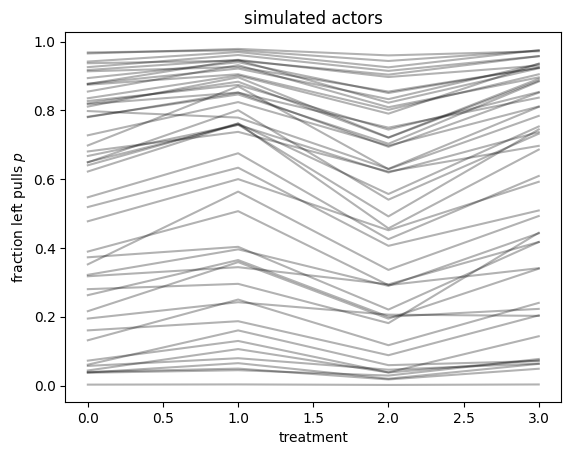

In [40]:
plt.plot(p[:50].T, color="black", alpha=0.3)
plt.xlabel("treatment")
plt.ylabel(r"fraction left pulls $p$")
plt.title("simulated actors")
plt.show()